In [4]:
import  os
import  pandas as pd
from    tqdm import tqdm
import  numpy as np
from    multiprocessing import get_context as context

# Read the files

# Parameters


header      = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']
PROCESSES   = os.cpu_count()-1
Pool        = context("fork").Pool

# Find the files
foldername  = f'../build/output'
os.system(f'rm -rf ../build/output/.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def parallel(function):
    def inner(input_array):
        # Parallelize excecution them
        with Pool(PROCESSES) as pool:
            output = list(tqdm(pool.imap(function, input_array),total=len(input_array)))
        return output 
    return inner

# Function to load a single file
def loadfile(filename):
    df = pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)
    df.insert(0, 'Filename', filename)
    return df

Found 8 data files in ../build/output


In [11]:
mm = 1
cm = 10
micron = 10**(-3)
nm = 10**(-6)

cryostatBottom = -698.771 * mm


copperThickness = 3 * mm
separation      = 2 * mm
copperBoxX      = 2.5 * cm
copperBoxY      = 2.5 * cm
copperBoxPosX   = 0 * cm
copperBoxPosY   = cryostatBottom + copperBoxY/2 + 11.5 * cm + copperThickness
copperBoxPosZ   = 0 * cm

stackX    = 0.5*mm + 150*2*nm + 500*2*nm
stackPosX = copperBoxPosX - copperBoxX/2 + copperThickness + separation + stackX/2
stackPosY = copperBoxPosY
stackPosZ = copperBoxPosZ

tesPosX   = stackX / 2 + 1 * micron / 2
tesPosY   = 0
tesPosZ   = 0

tesVolume = 20*20*1*micron**3

substratePosition = np.array([stackPosX, stackPosY, stackPosZ])
tesPosition       = np.array([tesPosX, tesPosY, tesPosZ])
tesPosition       = tesPosition + substratePosition
tesArea = 20 * 20 * micron**2

In [ ]:
def processFile(filename):
    """Filtering out tes hits according to"""

    # loading tes separately because of some error when using a copy
    # using A cos(a) / (4*pi*r^2) approach to calculate the energy that reaches tes 
    tes = loadfile(filename)
    tes = tes[tes.Volume.str.contains('Silicon')] # select only substrate volumes 
    tes['Distance'] = np.sqrt((tes.XPosition - tesPosition[0])**2 + (tes.YPosition - tesPosition[1])**2 + (tes.ZPosition - tesPosition[2])**2) # distance from a edep to tes
    tes['EnergyReached'] = tes.EnergyDeposited * tesArea * abs(tes.YPosition - tesPosition[1]) / (4 * np.pi * tes.Distance**3) # energy reached duh
    tes = tes.groupby('EventID')['EnergyReached'].sum().reset_index() # summing it per event
    tes = tes[tes.EnergyReached > 1*10**(-6)] # filtering out according to tes threshold

    # loading the rest of the dataframe
    data = loadfile(filename)
    data['hit'] = (data.EventID.isin(tes.EventID)).astype(int) # we assign event row a hit of 1 if it was registered by the tes above 
    data = data.groupby(['EventID', 'Volume', 'hit'])['EnergyDeposited'].sum().reset_index() # sum the energy per volume, hit and eventid are overlapping perfectly
    data = data[~(data.Volume.str.contains('Silicon')) & (data.EnergyDeposited > 0.2)] # removing substrate volumes and apply the sabers threshold
    data = data.groupby(['EventID', 'hit'])['Volume'].count().reset_index() # count how many sabers were hit during the event
    data['Triple'] = (data.Volume == 3).astype(int) # triplle coincidences
    data['Quadruple'] = ((data.hit == 1) & (data.Volume == 3)).astype(int) # quadruple 

    tesHits = len(tes)
    triple = sum(data.Triple)
    quad = sum(data.Quadruple)

    return (tesHits, triple, quad)

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
tripleEvents        = sum(processed[1])
quadrupleEvents     = sum(processed[2])

content = f"TES Hits = {tesHits}; Triple Coincidences = {tripleEvents}; Quadruple Coincidences = {quadrupleEvents}"
print(content)

  0%|          | 0/1024 [00:01<?, ?it/s]


NameError: name 'tesPosition' is not defined

In [42]:
def processFile(filename):
    file = loadfile(filename)
    file = file[file.Particle != 'alpha']
    # file = file[file.EnergyDeposited > 0.0]
    # file = file.groupby(['EventID', 'TrackID','Volume'])['EnergyDeposited'].sum().reset_index()

    tes = file[file.Volume.str.contains('Silicon')]
    tesIn = tes[tes.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tes[tes.MigrantID == -1]
    tes = pd.concat([tesOut, tesIn])
    tes = tes.drop(columns = 'MigrantID')
    tes = tes.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited > 0.0]
    
    saber = file[file.Volume.str.contains('Saber')]
    saberIn = saber[saber.MigrantID != -1]
    saberIn = saberIn.drop(columns = ['TrackID'])
    saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    saberOut = saber[saber.MigrantID == -1]
    saber = pd.concat([saberOut, saberIn])
    saber = saber.drop(columns = 'MigrantID')
    saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    saber = saber[saber.EnergyDeposited >= 0.2]
    
    # if len(pd.merge(saber,tes, on = ['EventID', 'TrackID'], how = 'inner')) != len(tes):
    #     print(filename)
    

    double = pd.merge(saber, tes, on = ['EventID', 'TrackID'], how = 'inner')
    if len(double) > 0:
        print(double)
    return (len(tes), len(saber), len(double))

processFiles        = parallel(processFile)
processed           = processFiles(filenames)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
saberHits           = sum(processed[1])
triple              = sum(processed[2])

content = f"TES Hits = {tesHits}; saber Hits = {saberHits}; Double Coincidences = {triple}"
print(content)

 15%|█▍        | 152/1024 [00:11<01:12, 11.96it/s]

   EventID  TrackID  EnergyDeposited_x  EnergyDeposited_y
0     4528       22           0.320668           0.083724


100%|██████████| 1024/1024 [01:15<00:00, 13.65it/s]

TES Hits = 8; saber Hits = 2006314; Double Coincidences = 1


  8%|▊         | 84/1024 [00:08<01:15, 12.50it/s]

TES-run0-rank61_nt_hits.csv


 15%|█▍        | 153/1024 [00:13<01:07, 12.86it/s]

TES-run0-rank828_nt_hits.csv


 20%|██        | 205/1024 [00:16<00:41, 19.51it/s]

TES-run0-rank636_nt_hits.csv
TES-run0-rank338_nt_hits.csv


 44%|████▍     | 448/1024 [00:34<00:50, 11.32it/s]

TES-run0-rank278_nt_hits.csv


 58%|█████▊    | 591/1024 [00:46<00:45,  9.53it/s]

TES-run0-rank443_nt_hits.csv


 81%|████████  | 825/1024 [01:02<00:17, 11.42it/s]

TES-run0-rank319_nt_hits.csv


 93%|█████████▎| 951/1024 [01:12<00:10,  7.12it/s]

TES-run0-rank849_nt_hits.csv

 94%|█████████▍| 963/1024 [01:12<00:03, 17.12it/s]

 98%|█████████▊| 1000/1024 [01:15<00:01, 17.16it/s]

TES-run0-rank512_nt_hits.csv


100%|██████████| 1024/1024 [01:16<00:00, 13.30it/s]


TES Hits = 1596; saber Hits = 43272365; Double Coincidences = 1587


In [13]:
weirdFiles = ['TES-run0-rank61_nt_hits.csv', 'TES-run0-rank828_nt_hits.csv', 'TES-run0-rank636_nt_hits.csv', 'TES-run0-rank338_nt_hits.csv', 'TES-run0-rank278_nt_hits.csv',
              'TES-run0-rank443_nt_hits.csv', 'TES-run0-rank319_nt_hits.csv', 'TES-run0-rank849_nt_hits.csv', 'TES-run0-rank512_nt_hits.csv']

In [14]:
loadfiles = parallel(loadfile)

In [15]:
weirdData = pd.concat(loadfiles(weirdFiles))

100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


In [11]:
def processFile(filename):
    file = loadfile(filename)
    file = file[file.Particle != 'alpha']
    # file = file[file.EnergyDeposited > 0.0]
    # file = file.groupby(['EventID', 'TrackID','Volume'])['EnergyDeposited'].sum().reset_index()

    tes = file[file.Volume.str.contains('Silicon')]
    tesIn = tes[tes.MigrantID != -1]
    tesIn = tesIn.drop(columns = ['TrackID'])
    tesIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    tesOut = tes[tes.MigrantID == -1]
    tes = pd.concat([tesOut, tesIn])
    tes = tes.drop(columns = 'MigrantID')
    tes = tes.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    tes = tes[tes.EnergyDeposited >= 0.0]
    
    saber = file[file.Volume.str.contains('Saber')]
    saberIn = saber[saber.MigrantID != -1]
    saberIn = saberIn.drop(columns = ['TrackID'])
    saberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

    saberOut = saber[saber.MigrantID == -1]
    saber = pd.concat([saberOut, saberIn])
    saber = saber.drop(columns = 'MigrantID')
    saber = saber.groupby(['EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
    saber = saber[saber.EnergyDeposited >= 0.2]
    
    # if len(pd.merge(saber,tes, on = ['EventID', 'TrackID'], how = 'inner')) != len(tes):
    #     print(filename)
    

    double = pd.merge(tes, saber, on = ['EventID', 'TrackID'], how = 'inner')
    print(double)
    return (len(tes), len(saber), len(double))

processFiles        = parallel(processFile)
processed           = processFiles(weirdFiles)
processed           = np.array(processed).T

tesHits             = sum(processed[0])
saberHits           = sum(processed[1])
triple              = sum(processed[2])

content = f"TES Hits = {tesHits}; saber Hits = {saberHits}; Double Coincidences = {triple}"
print(content)

100%|██████████| 9/9 [00:01<00:00,  5.78it/s]

TES Hits = 17; saber Hits = 378758; Double Coincidences = 8


In [16]:
weirdData = weirdData[weirdData.Particle != 'alpha']

In [17]:
weirdTES = weirdData[weirdData.Volume.str.contains('Silicon')]
weirdTESIn = weirdTES[weirdTES.MigrantID != -1]
weirdTESIn = weirdTESIn.drop(columns = ['TrackID'])
weirdTESIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

weirdTESOut = weirdTES[weirdTES.MigrantID == -1]
weirdTES = pd.concat([weirdTESOut, weirdTESIn])
weirdTES = weirdTES.drop(columns = 'MigrantID')
weirdTES = weirdTES.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
weirdTES = weirdTES[weirdTES.EnergyDeposited >= 0.0]
weirdTES

,Filename,EventID,TrackID,EnergyDeposited
0,TES-run0-rank278_nt_hits.csv,3292,5,0.000000
1,TES-run0-rank278_nt_hits.csv,3716,11,0.000000
2,TES-run0-rank278_nt_hits.csv,6488,22,0.000000
3,TES-run0-rank278_nt_hits.csv,9688,17,0.000000
4,TES-run0-rank319_nt_hits.csv,378,21,0.000000
5,TES-run0-rank319_nt_hits.csv,7930,17,0.000000
6,TES-run0-rank338_nt_hits.csv,3535,16,0.000000
7,TES-run0-rank443_nt_hits.csv,7851,14,0.000000
8,TES-run0-rank443_nt_hits.csv,8330,28,0.000000
9,TES-run0-rank512_nt_hits.csv,984,16,0.000000


In [18]:
weirdSaber = weirdData[weirdData.Volume.str.contains('Saber')]
weirdSaberIn = weirdSaber[weirdSaber.MigrantID != -1]
weirdSaberIn = weirdSaberIn.drop(columns = ['TrackID'])
weirdSaberIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)

weirdSaberOut = weirdSaber[weirdSaber.MigrantID == -1]
weirdSaber = pd.concat([weirdSaberOut, weirdSaberIn])
weirdSaber = weirdSaber.drop(columns = 'MigrantID')
weirdSaber = weirdSaber.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
weirdSaber = weirdSaber[weirdSaber.EnergyDeposited >= 0.0]
weirdSaber

,Filename,EventID,TrackID,EnergyDeposited
0,TES-run0-rank278_nt_hits.csv,1,6,0.005651
1,TES-run0-rank278_nt_hits.csv,1,8,0.001250
2,TES-run0-rank278_nt_hits.csv,1,9,0.015486
3,TES-run0-rank278_nt_hits.csv,1,11,0.000011
4,TES-run0-rank278_nt_hits.csv,1,17,0.000000
...,...,...,...,...
378753,TES-run0-rank849_nt_hits.csv,9762,29,0.016836
378754,TES-run0-rank849_nt_hits.csv,9764,14,0.000000
378755,TES-run0-rank849_nt_hits.csv,9764,17,0.411676
378756,TES-run0-rank849_nt_hits.csv,9764,23,0.004832


In [21]:
weird = pd.merge(weirdTES, weirdSaber, on = ['Filename','EventID', 'TrackID'], how = 'left').fillna('what')
weird = weird[weird.EnergyDeposited_y == 'what']
weird

,Filename,EventID,TrackID,EnergyDeposited_x,EnergyDeposited_y
3,TES-run0-rank278_nt_hits.csv,9688,17,0.000000,what
5,TES-run0-rank319_nt_hits.csv,7930,17,0.000000,what
6,TES-run0-rank338_nt_hits.csv,3535,16,0.000000,what
8,TES-run0-rank443_nt_hits.csv,8330,28,0.000000,what
9,TES-run0-rank512_nt_hits.csv,984,16,0.000000,what
10,TES-run0-rank61_nt_hits.csv,740,14,0.000000,what
12,TES-run0-rank636_nt_hits.csv,1629,26,0.238516,what
14,TES-run0-rank828_nt_hits.csv,1297,25,0.030595,what
16,TES-run0-rank849_nt_hits.csv,3660,14,0.000000,what


In [38]:
file = loadfile('TES-run0-rank828_nt_hits.csv')
file = file[(file.EventID == 1297) & (file.TrackID == 25)]

In [39]:
file

,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
80162,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000093,-7.49999,-584.690,-1.54123,0.034158,physDetectorSiliconNitride2,160.193,logicCopperBox_PV,-1
80163,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000114,-7.49998,-584.690,-1.54121,0.034158,physDetectorSiliconNitride2,160.193,logicCopperBox_PV,-1
80164,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000000,-7.49997,-584.690,-1.54121,0.034158,physDetectorSiliconNitride2,160.193,logicCopperBox_PV,-1
80165,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000000,-7.49996,-584.690,-1.54120,0.034158,physDetectorSiliconNitride2,160.193,logicCopperBox_PV,-1
80166,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000194,-7.49990,-584.690,-1.54113,0.034160,physDetectorSiliconNitride2,160.193,logicCopperBox_PV,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80227,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000332,-7.49859,-584.693,-1.54138,0.034227,physDetectorSiliconSubstrate,160.193,logicCopperBox_PV,-1
80228,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.000052,-7.49852,-584.693,-1.54133,0.034229,physDetectorSiliconSubstrate,160.193,logicCopperBox_PV,-1
80229,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.002200,-7.49845,-584.693,-1.54128,0.034231,physDetectorSiliconSubstrate,160.193,logicCopperBox_PV,-1
80230,TES-run0-rank828_nt_hits.csv,1297,25,e-,0.006206,-7.49829,-584.693,-1.54118,0.034235,physDetectorSiliconSubstrate,160.193,logicCopperBox_PV,-1


In [27]:
loadfiles = parallel(loadfile)

In [28]:
df = pd.concat(loadfiles(filenames))

100%|██████████| 8/8 [00:00<00:00, 240.00it/s]


In [29]:
df

,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
0,TES_nt_hits_t7.csv,1,31,gamma,0.0,-8.89920,2.25193,2.151150,0.045845,physDetectorSiliconNitride1,463.009,logicCopperBox_PV,-1
1,TES_nt_hits_t7.csv,1,31,gamma,0.0,-8.89935,2.25222,2.151200,0.045846,physDetectorSiliconOxide1,463.009,logicCopperBox_PV,-1
2,TES_nt_hits_t7.csv,1,31,gamma,0.0,-9.02819,2.50000,2.193480,0.046789,physDetectorSiliconSubstrate,463.009,logicCopperBox_PV,-1
3,TES_nt_hits_t7.csv,79,22,gamma,0.0,-9.39950,-1.43753,-1.976050,0.016289,physDetectorSiliconNitride2,231.394,logicCopperBox_PV,-1
4,TES_nt_hits_t7.csv,79,22,gamma,0.0,-9.39935,-1.43733,-1.976070,0.016289,physDetectorSiliconOxide2,231.394,logicCopperBox_PV,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9326,TES_nt_hits_t3.csv,993915,13,anti_nu_e,0.0,-8.89920,1.96107,-0.421231,0.007431,physDetectorSiliconOxide1,1000.630,logicCopperBox_PV,-1
9327,TES_nt_hits_t3.csv,993915,13,anti_nu_e,0.0,-8.89870,1.96063,-0.420924,0.007433,physDetectorSiliconNitride1,1000.630,logicCopperBox_PV,-1
9328,TES_nt_hits_t3.csv,993938,19,anti_nu_e,0.0,-9.39950,-1.35257,2.164030,0.016437,physDetectorSiliconNitride2,859.125,logicCopperBox_PV,-1
9329,TES_nt_hits_t3.csv,993938,19,anti_nu_e,0.0,-9.39935,-1.35246,2.164950,0.016440,physDetectorSiliconOxide2,859.125,logicCopperBox_PV,-1


In [30]:
dfIn = df[df.MigrantID != -1]
dfIn = dfIn.drop(columns = ['TrackID'])
dfIn.rename(columns = {'MigrantID':'TrackID'}, inplace = True)
dfIn

,Filename,EventID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,TrackID
14,TES_nt_hits_t7.csv,79,e-,0.002352,-9.13615,-0.321432,0.187688,0.000038,physDetectorSiliconSubstrate,105.687,physDetectorSiliconSubstrate,32
15,TES_nt_hits_t7.csv,79,e-,0.021836,-9.14036,-0.301835,0.188483,0.000159,physDetectorSiliconSubstrate,105.687,physDetectorSiliconSubstrate,32
16,TES_nt_hits_t7.csv,79,e-,0.020315,-9.12783,-0.302372,0.196194,0.000256,physDetectorSiliconSubstrate,105.687,physDetectorSiliconSubstrate,32
17,TES_nt_hits_t7.csv,79,e-,0.020533,-9.12559,-0.306051,0.205039,0.000329,physDetectorSiliconSubstrate,105.687,physDetectorSiliconSubstrate,32
18,TES_nt_hits_t7.csv,79,e-,0.024296,-9.12701,-0.307473,0.200393,0.000373,physDetectorSiliconSubstrate,105.687,physDetectorSiliconSubstrate,32
...,...,...,...,...,...,...,...,...,...,...,...,...
9063,TES_nt_hits_t3.csv,971056,e-,0.002428,-9.32558,-0.151810,-1.901290,0.000019,physDetectorSiliconSubstrate,61.979,physDetectorSiliconSubstrate,5
9064,TES_nt_hits_t3.csv,971056,e-,0.022045,-9.31791,-0.153202,-1.895960,0.000090,physDetectorSiliconSubstrate,61.979,physDetectorSiliconSubstrate,5
9065,TES_nt_hits_t3.csv,971056,e-,0.023701,-9.31575,-0.156975,-1.895290,0.000130,physDetectorSiliconSubstrate,61.979,physDetectorSiliconSubstrate,5
9066,TES_nt_hits_t3.csv,971056,e-,0.013806,-9.31556,-0.157535,-1.894820,0.000141,physDetectorSiliconSubstrate,61.979,physDetectorSiliconSubstrate,5


In [31]:
dfOut = df[df.MigrantID == -1]
dfOut

,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
0,TES_nt_hits_t7.csv,1,31,gamma,0.0,-8.89920,2.25193,2.151150,0.045845,physDetectorSiliconNitride1,463.009,logicCopperBox_PV,-1
1,TES_nt_hits_t7.csv,1,31,gamma,0.0,-8.89935,2.25222,2.151200,0.045846,physDetectorSiliconOxide1,463.009,logicCopperBox_PV,-1
2,TES_nt_hits_t7.csv,1,31,gamma,0.0,-9.02819,2.50000,2.193480,0.046789,physDetectorSiliconSubstrate,463.009,logicCopperBox_PV,-1
3,TES_nt_hits_t7.csv,79,22,gamma,0.0,-9.39950,-1.43753,-1.976050,0.016289,physDetectorSiliconNitride2,231.394,logicCopperBox_PV,-1
4,TES_nt_hits_t7.csv,79,22,gamma,0.0,-9.39935,-1.43733,-1.976070,0.016289,physDetectorSiliconOxide2,231.394,logicCopperBox_PV,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9326,TES_nt_hits_t3.csv,993915,13,anti_nu_e,0.0,-8.89920,1.96107,-0.421231,0.007431,physDetectorSiliconOxide1,1000.630,logicCopperBox_PV,-1
9327,TES_nt_hits_t3.csv,993915,13,anti_nu_e,0.0,-8.89870,1.96063,-0.420924,0.007433,physDetectorSiliconNitride1,1000.630,logicCopperBox_PV,-1
9328,TES_nt_hits_t3.csv,993938,19,anti_nu_e,0.0,-9.39950,-1.35257,2.164030,0.016437,physDetectorSiliconNitride2,859.125,logicCopperBox_PV,-1
9329,TES_nt_hits_t3.csv,993938,19,anti_nu_e,0.0,-9.39935,-1.35246,2.164950,0.016440,physDetectorSiliconOxide2,859.125,logicCopperBox_PV,-1


In [32]:
df = pd.concat([dfIn, dfOut])
df = df.groupby(['Filename','EventID', 'TrackID'])['EnergyDeposited'].sum().reset_index()
df = df[df.EnergyDeposited > 0.0]
df
len(df)

470

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

(array([240.,  73.,  58.,  29.,  24.,  13.,   9.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   1.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,
          2.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          2.,   1.,   0.,   0.,   1.,   1.]),
 array([4.28800000e-05, 1.08137722e-01, 2.16232565e-01, 3.24327407e-01,
        4.32422250e-01, 5.40517092e-01, 6.48611934e-01, 7.56706777e-01,
        8.64801619e-01, 9.72896462e-01, 1.08099130e+00, 1.18908615e+00,
        1.29718099e+00, 1.40527583e+00, 1.51337067e+00, 1.62146552e+00,
        1.72956036e+00, 1.83765520e+00, 1.94575004e+00, 2.05384489e+00,
        2.16193973e+00, 2.27003457e+00, 2.37812941e+00, 2.48622426e+00,
        2.59431910e+00, 2.70241394e+00, 2.81050878e+00, 2.91860362e+00,
        3.02669847e+00, 3.13479331e+00, 3.24288815e+00, 3.35098299e+00,
        3.45907784e+00, 3.56717268e+00, 3.67526752e+00, 3.78336236e+00,
        3.

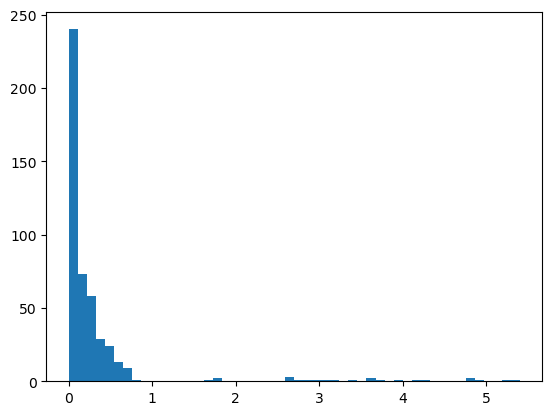

In [35]:
plt.hist(df.EnergyDeposited, bins = 50)